<a href="https://colab.research.google.com/github/hhduke2014/marked-beetle-analysis/blob/main/Prediction_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")

In [4]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [5]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [6]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl20d.tif,marked
1,PaperedControl21v.tif,marked
2,PaperedControl21d.tif,marked
3,PaperedControl22v.tif,marked
4,PaperedControl22d.tif,marked
...,...,...
752,PaperedControl18v.tif,marked
753,PaperedControl18d.tif,marked
754,PaperedControl19v.tif,marked
755,PaperedControl19d.tif,marked


In [7]:
import keras

final_model = keras.models.load_model('resnet_model.h5')

In [33]:
humanDF = pd.read_csv(
    "/content/drive/MyDrive/HumanClassifier/HumanClassication.csv"
)
humanDF.shape

(757, 4)

In [34]:
humanDF

,name,Class,ext,marked
0,PaperedControl13d.tif,Y,tif,Y
1,PaperedTransparent105v.tif,N,tif,Y
2,PaperedTransparent105d.tif,Y,tif,Y
3,PaperedTransparent104v.tif,Y,tif,Y
4,PaperedTransparent104d.tif,Y,tif,Y
...,...,...,...,...
752,NoPaperedGreen89d.tif,N,tif,N
753,NoPaperedGreen88v.tif,N,tif,N
754,NoPaperedGreen88d.tif,N,tif,N
755,NoPaperedGreen87v.tif,N,tif,N


In [35]:
humanDF.rename(columns={"marked":"human prediction"})
humanDF.head()

,name,Class,ext,marked
0,PaperedControl13d.tif,Y,tif,Y
1,PaperedTransparent105v.tif,N,tif,Y
2,PaperedTransparent105d.tif,Y,tif,Y
3,PaperedTransparent104v.tif,Y,tif,Y
4,PaperedTransparent104d.tif,Y,tif,Y


In [36]:
humanDF["category"] = humanDF["marked"].replace({'N': 'unmarked', 'Y': 'marked'}) 
humanDF["HumanClassifier"] = humanDF["Class"].replace({'N': 'unmarked', 'Y': 'marked'}) 
humanDF

,name,Class,ext,marked,category,HumanClassifier
0,PaperedControl13d.tif,Y,tif,Y,marked,marked
1,PaperedTransparent105v.tif,N,tif,Y,marked,unmarked
2,PaperedTransparent105d.tif,Y,tif,Y,marked,marked
3,PaperedTransparent104v.tif,Y,tif,Y,marked,marked
4,PaperedTransparent104d.tif,Y,tif,Y,marked,marked
...,...,...,...,...,...,...
752,NoPaperedGreen89d.tif,N,tif,N,unmarked,unmarked
753,NoPaperedGreen88v.tif,N,tif,N,unmarked,unmarked
754,NoPaperedGreen88d.tif,N,tif,N,unmarked,unmarked
755,NoPaperedGreen87v.tif,N,tif,N,unmarked,unmarked


In [25]:
to_samples = humanDF.shape[0]

In [40]:
size=(224,224)
BATCH_SIZE=32
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    humanDF, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='name',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 757 validated image filenames.


In [41]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [42]:
humanDF['MachineClassifier'] = np.argmax(predict, axis=-1)
humanDF["MachineClassifier"] = humanDF["MachineClassifier"].replace({1: 'unmarked', 0: 'marked'}) 
humanDF

,name,Class,ext,marked,category,HumanClassifier,MachineClassifier
0,PaperedControl13d.tif,Y,tif,Y,marked,marked,marked
1,PaperedTransparent105v.tif,N,tif,Y,marked,unmarked,marked
2,PaperedTransparent105d.tif,Y,tif,Y,marked,marked,marked
3,PaperedTransparent104v.tif,Y,tif,Y,marked,marked,marked
4,PaperedTransparent104d.tif,Y,tif,Y,marked,marked,marked
...,...,...,...,...,...,...,...
752,NoPaperedGreen89d.tif,N,tif,N,unmarked,unmarked,unmarked
753,NoPaperedGreen88v.tif,N,tif,N,unmarked,unmarked,marked
754,NoPaperedGreen88d.tif,N,tif,N,unmarked,unmarked,unmarked
755,NoPaperedGreen87v.tif,N,tif,N,unmarked,unmarked,marked


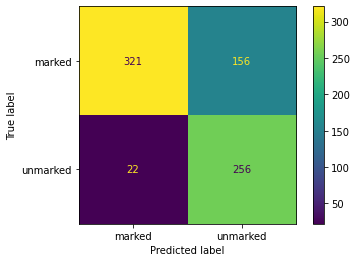

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(humanDF['category'])
y_pred=list(humanDF['HumanClassifier'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

In [46]:
humanDF['HumanClassifier'].value_counts()

unmarked    412
marked      343
Name: HumanClassifier, dtype: int64

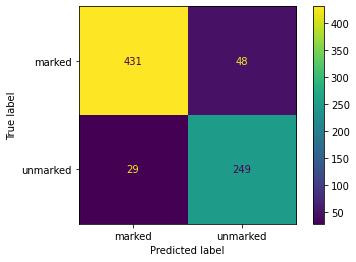

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(humanDF['category'])
y_pred=list(humanDF['MachineClassifier'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")